# Group Lab


## Lab: 5
## Section: BSCS-12-A
## Member 1:
- Name: Ahmed Mohiuddin Shah
- CMS ID: 415216

## Member 2:
- Name: Muhammad Sarmad Saleem
- CMS ID: 411411

# Lab

## Importing libraries

In [2]:
%pip install opencv-python matplotlib numpy

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Note: you may need to restart the kernel to use updated packages.


## Creating Folder Structure

In [3]:
def create_folder_structure():

    # delete the processed folder if it exists
    if os.path.exists("processed"):
        os.system("rm -r processed")

    # Create the processed folder
    if not os.path.exists("processed"):
        os.makedirs("processed")

    # Create the centroid folder
    if not os.path.exists("processed/centroid"):
        os.makedirs("processed/centroid")

    # Create the ratio folder
    if not os.path.exists("processed/ratio"):
        os.makedirs("processed/ratio")

    # Create the transitions folder
    if not os.path.exists("processed/transitions"):
        os.makedirs("processed/transitions")

    # Create the images folder
    if not os.path.exists("processed/images"):
        os.makedirs("processed/images")

    # Create the skew folder
    if not os.path.exists("processed/skew"):
        os.makedirs("processed/skew")

    # Create the slant folder
    if not os.path.exists("processed/slant"):
        os.makedirs("processed/slant")

    print("Folder Structure Created")

## Creating Binary Image

In [4]:
def process_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 10
    )
    invert = cv2.bitwise_not(binary)
    return invert

## 1. Creating Bounding Box
- Develop a bounding box around the signature content.

In [5]:
def developing_bounding_box_around_signature(image) -> tuple:

    x, y, w, h = 0, 0, 0, 0

    for row in range(image.shape[0]):
        if 0 in image[row]:
            y = row
            break

    for row in range(image.shape[0] - 1, 0, -1):
        if 0 in image[row]:
            h = row - y
            break

    for col in range(image.shape[1]):
        if 0 in image[:, col]:
            x = col
            break

    for col in range(image.shape[1] - 1, 0, -1):
        if 0 in image[:, col]:
            w = col - x
            break

    return x, y, w, h

## 2. Finding Centroid
-  Find out the centroid of the signature.

In [6]:
def locate_signature_centroid(image):

    if image is None or image.shape[0] == 0 or image.shape[1] == 0:
        return 0, 0

    image = process_image(image)

    cx = 0
    cy = 0
    n = 0

    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if (image[row, col]) == 0:
                cy += row
                cx += col
                n += 1

    if n > 0:
        cx = int(cx / n)
        cy = int(cy / n)

    return cx, cy

## 3. Segmenting Signature
- Segment signature from centroid vertically and horizontally (the signature will be divided 
into four pieces)


In [7]:
def divide_signature_into_four_segments(image, cx, cy):
    top_left = image[0:cy, 0:cx]
    top_right = image[0:cy, cx : image.shape[1]]
    bottom_left = image[cy : image.shape[0], 0:cx]
    bottom_right = image[cy : image.shape[0], cx : image.shape[1]]

    return top_left, top_right, bottom_left, bottom_right


def crop_image(image):

    new_image = process_image(image)

    x, y, w, h = developing_bounding_box_around_signature(new_image)

    image = image[y : y + h, x : x + w]

    return image

## 4. Calculate black to white transitions

In [8]:
def black_to_white_transitions(image):

    if image is None or image.shape[0] == 0 or image.shape[1] == 0:
        return 0

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    transitions = 0

    image = np.array(image)

    for row in range(1, image.shape[0]):
        for col in range(1, image.shape[1]):
            if image[row, col] < 125 and image[row, col - 1] > 125:
                transitions += 1
            if image[row, col] < 125 and image[row, col - 1] > 125:
                transitions += 1

    return transitions

## Calculating ratios

`if image.shape[1] != 0:`

`r = image.shape[0] / image.shape[1]`

`else:`

`r = 0`

## 6. Computing:

### Skew angle

In [9]:
def compute_skew_angle(image):
    """
    Compute the skew angle of the given binary image.
    """
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angles = []
    if lines is not None:
        for rho, theta in lines[:, 0]:
            angle = (theta - np.pi / 2) * (180 / np.pi)  # Convert radian to degree
            angles.append(angle)
    if len(angles) > 0:
        return np.median(angles)  # Take the median of angles for a robust estimation
    return 0

### Slant angle

In [10]:
def compute_slant_angle(image):
    """
    Compute the slant angle of strokes in the given binary image.
    """
    coords = np.column_stack(np.where(image == 0))  # Get coordinates of black pixels
    if len(coords) > 1:
        pca = cv2.PCACompute(coords.astype(np.float32), mean=None)
        angle = np.arctan2(pca[1][0, 1], pca[1][0, 0]) * (
            180 / np.pi
        )  # Convert radian to degree
        return angle
    return 0

## Recursive Algo to split Signature

In [11]:
def split_image(image, image_test, depth=0, image_name=""):
    cx, cy = locate_signature_centroid(image)

    if depth < 3:
        # draw centroid lines
        top_left, top_right, bottom_left, bottom_right = (
            divide_signature_into_four_segments(image, cx, cy)
        )
        top_left_test, top_right_test, bottom_left_test, bottom_right_test = (
            divide_signature_into_four_segments(image_test, cx, cy)
        )

        split_image(top_left, top_left_test, depth + 1, image_name)
        split_image(top_right, top_right_test, depth + 1, image_name)
        split_image(bottom_left, bottom_left_test, depth + 1, image_name)
        split_image(bottom_right, bottom_right_test, depth + 1, image_name)
    else:
        t = black_to_white_transitions(image)
        if image.shape[1] != 0:
            r = image.shape[0] / image.shape[1]
        else:
            r = 0

        skew_angle = compute_skew_angle(image)
        slant_angle = compute_slant_angle(image)

        # draw box using the image_test
        cv2.rectangle(
            image_test,
            (0, 0),
            (image_test.shape[1], image_test.shape[0]),
            (0, 0, 255),
            1,
        )

        # save the transition count and aspect ratio in respective text files
        with open(f"processed/centroid/{image_name}.txt", "a") as f:
            f.write(f"{cx} {cy}\n")
        with open(f"processed/transitions/{image_name}.txt", "a") as f:
            f.write(f"{t}\n")
        with open(f"processed/ratio/{image_name}.txt", "a") as f:
            f.write(f"{r}\n")
        with open(f"processed/skew/{image_name}.txt", "a") as f:
            f.write(f"{skew_angle}\n")
        with open(f"processed/slant/{image_name}.txt", "a") as f:
            f.write(f"{slant_angle}\n")

    return image_test

## Get Stable black to white transition Signature

In [12]:
def get_stable_black_to_white_signature():

    # Load the transition data from the text files
    transition_data = {}
    for file_name in os.listdir("processed/transitions"):
        with open(f"processed/transitions/{file_name}", "r") as file:
            transition_data[file_name] = [
                int(transition) for transition in file.readlines()
            ]

    # Calculate the variance of transition counts for each signature
    transition_variances = {
        file_name: np.var(transitions)
        for file_name, transitions in transition_data.items()
    }

    # Get the signature with the most stable transition count
    stable_signature = min(transition_variances, key=transition_variances.get)

    return stable_signature

## Calculating Stable Skew Slant Signature

In [13]:
def analyze_skew_slant_stability():

    # Load the skew and slant data from the text files
    skew_data = {}
    slant_data = {}

    for file_name in os.listdir("processed/skew"):
        with open(f"processed/skew/{file_name}", "r") as file:
            skew_data[file_name] = [float(angle) for angle in file.readlines()]

        with open(f"processed/slant/{file_name}", "r") as file:
            slant_data[file_name] = [float(angle) for angle in file.readlines()]

    # Calculate the variance of skew and slant angles for each signature
    skew_variances = {
        file_name: np.var(angles) for file_name, angles in skew_data.items()
    }
    slant_variances = {
        file_name: np.var(angles) for file_name, angles in slant_data.items()
    }

    # Get the signature with the most stable skew angle
    stable_skew = min(skew_variances, key=skew_variances.get)

    # Get the signature with the most stable slant angle

    stable_slant = min(slant_variances, key=slant_variances.get)

    return stable_skew, stable_slant

# Main Task


Folder Structure Created


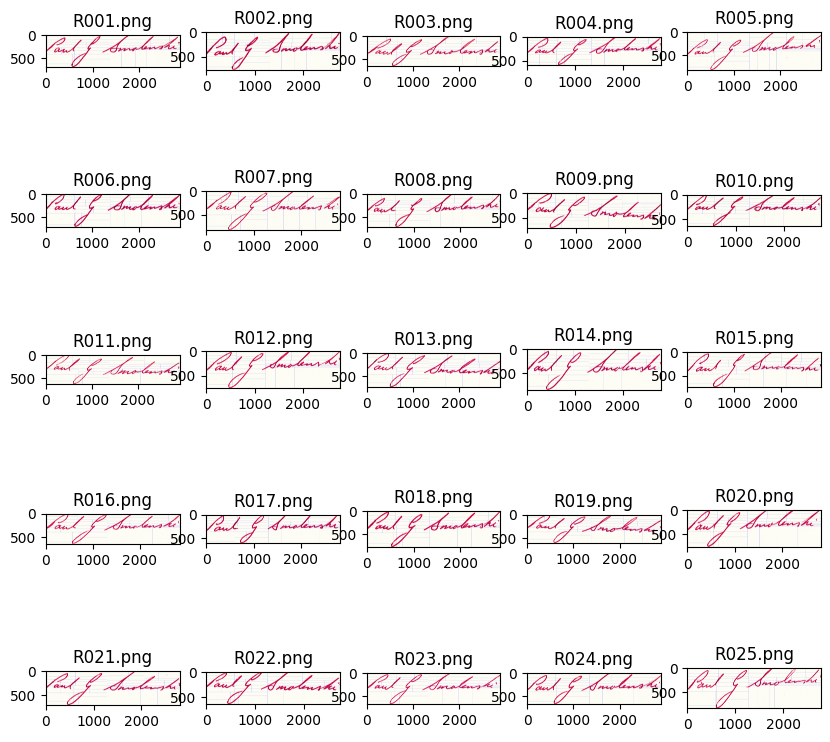

Most stable signature based on black to white transitions: R019.txt
Most stable signature based on skew and slant angles: ('R001.txt', 'R021.txt')


In [14]:
def main():

    create_folder_structure()

    # create plt grid
    plt.figure(figsize=(10, 10))

    for image_name in os.listdir("./images"):
        # R001.png, R002.png, R003.png, R004.png, R005.png - R025.png
        image = cv2.imread(f"./images/{image_name}")

        cropped_image = crop_image(image.copy())
        copy_cropped_image = cropped_image.copy()

        new_image = split_image(
            cropped_image, copy_cropped_image, 0, image_name.split(".")[0]
        )

        cv2.imwrite(
            f'processed/images/{image_name.split(".")[0]}_processed.png', new_image
        )

        # show the processed image on plt grid
        plt.subplot(5, 5, int(image_name[1:4]))
        plt.imshow(new_image)
        plt.title(image_name)

    plt.show()

    # Calculate stability

    print(
        "Most stable signature based on black to white transitions:",
        get_stable_black_to_white_signature(),
    )
    print(
        "Most stable signature based on skew and slant angles:",
        analyze_skew_slant_stability(),
    )

main()